In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 1.

In [31]:
# a)
file_path = "date_alegeri_turul2.csv"
data = pd.read_csv(file_path)

data["Varsta"] = (data["Varsta"] - data["Varsta"].mean()) / data["Varsta"].std()
data["Sex"] = (data["Sex"] - data["Sex"].mean()) / data["Sex"].std()
data["Educatie"] = (data["Educatie"] - data["Educatie"].mean()) / data["Educatie"].std()
data["Venit"] = (data["Venit"] - data["Venit"].mean()) / data["Venit"].std()

with pm.Model() as logistic_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    beta_varsta = pm.Normal("beta_varsta", mu=0, sigma=10)
    beta_sex = pm.Normal("beta_sex", mu=0, sigma=10)
    beta_educatie = pm.Normal("beta_educatie", mu=0, sigma=10)
    beta_venit = pm.Normal("beta_venit", mu=0, sigma=10)

    logit_p = (
        intercept
        + beta_varsta * data["Varsta"]
        + beta_sex * data["Sex"]
        + beta_educatie * data["Educatie"]
        + beta_venit * data["Venit"]
    )

    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))
    vot_obs = pm.Bernoulli("vot_obs", p=p, observed=data["Vot"])

    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Output()

Output()

In [13]:
# b)
summary = az.summary(trace, hdi_prob=0.95)

print(summary[["mean", "hdi_2.5%", "hdi_97.5%"]])

# Venitul (beta_venit = 1.011) – datorită coef. ridicat, venitul are cel mai mare efect pozitiv asupra prob. de a vota pentru candidatul A.
# Un venit mai mare creste semnificativ prob. ca o persoană să voteze pentru candidatul A.

# Educatia (beta_educatie = 0.487) – deși coef. este mai mic decât cel al venitului, educația are un efect vizibil asupra prob. de a vota pentru candidatul A.
# Persoanele cu un nivel mai ridicat de educatie sunt mai predispuse să voteze pentru candidatul A.

                mean  hdi_2.5%  hdi_97.5%
beta_educatie  0.491     0.233      0.737
beta_sex      -0.426    -0.669     -0.173
beta_varsta    0.292     0.028      0.532
beta_venit     1.011     0.719      1.288
intercept      1.741     1.460      2.027
...              ...       ...        ...
p[495]         0.981     0.966      0.992
p[496]         0.681     0.573      0.780
p[497]         0.887     0.844      0.924
p[498]         0.878     0.817      0.936
p[499]         0.949     0.913      0.978

[505 rows x 3 columns]


Output()

Output()

<ipython-input-36-88bfb2552f20>:57: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(


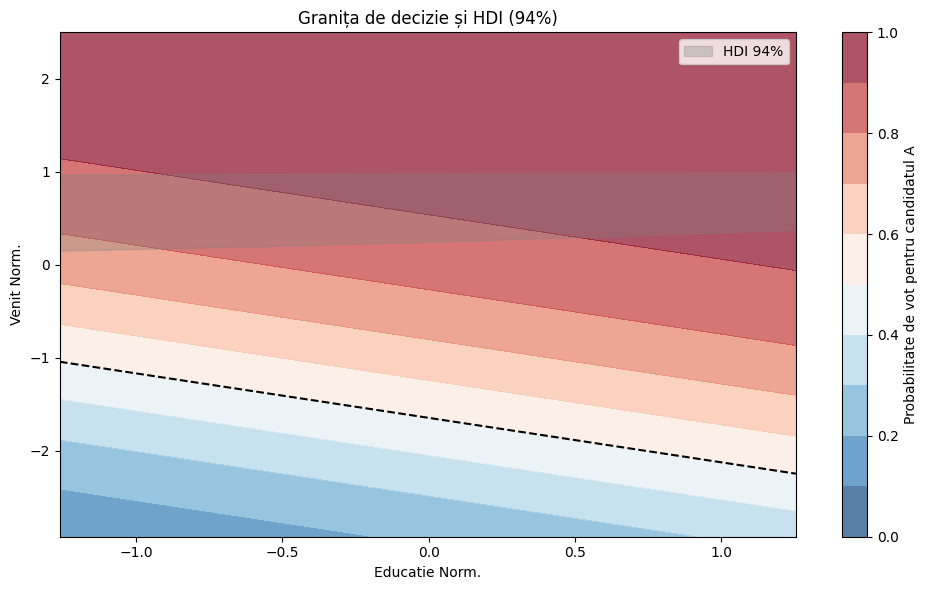

In [36]:
data["Educatie"] = (data["Educatie"] - data["Educatie"].mean()) / data["Educatie"].std()
data["Venit"] = (data["Venit"] - data["Venit"].mean()) / data["Venit"].std()

with pm.Model() as reduced_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    beta_educatie = pm.Normal("beta_educatie", mu=0, sigma=10)
    beta_venit = pm.Normal("beta_venit", mu=0, sigma=10)

    logit_p = (
        intercept
        + beta_educatie * data["Educatie"]
        + beta_venit * data["Venit"]
    )
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))
    vot_obs = pm.Bernoulli("vot_obs", p=p, observed=data["Vot"])

    trace_reduced = pm.sample(2000, tune=1000, return_inferencedata=True)

educatie_vals = np.linspace(data["Educatie"].min(), data["Educatie"].max(), 100)
venit_vals = np.linspace(data["Venit"].min(), data["Venit"].max(), 100)
educatie_grid, venit_grid = np.meshgrid(educatie_vals, venit_vals)
grid = np.column_stack([educatie_grid.ravel(), venit_grid.ravel()])

with reduced_model:
    prob_grid = (
        trace_reduced.posterior["intercept"].mean().item()
        + trace_reduced.posterior["beta_educatie"].mean().item() * grid[:, 0]
        + trace_reduced.posterior["beta_venit"].mean().item() * grid[:, 1]
    )
    prob_grid = pm.math.sigmoid(prob_grid).eval()

prob_grid = prob_grid.reshape(educatie_grid.shape)

lower_hdi = np.percentile(prob_grid, 3, axis=0)
upper_hdi = np.percentile(prob_grid, 97, axis=0)

plt.figure(figsize=(10, 6))

plt.contourf(
    educatie_grid,
    venit_grid,
    prob_grid,
    levels=np.linspace(0, 1, 11),
    cmap="RdBu_r",
    alpha=0.7
)
plt.colorbar(label="Probabilitate de vot pentru candidatul A")

plt.contour(
    educatie_grid,
    venit_grid,
    prob_grid,
    levels=[0.5],
    colors="black",
    linewidths=1.5,
    linestyles="--",
    label="Granița de decizie (p=0.5)"
)

plt.fill_between(
    educatie_vals,
    lower_hdi,
    upper_hdi,
    color="gray",
    alpha=0.3,
    label="HDI 94%"
)

plt.xlabel("Educatie Norm.")
plt.ylabel("Venit Norm.")
plt.title("Granița de decizie și HDI (94%)")
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# d)
waic_full = az.waic(trace)
loo_full = az.loo(trace)

waic_reduced = az.waic(trace_reduced)
loo_reduced = az.loo(trace_reduced)

comparison = az.compare({"Full Model (a)": trace, "Reduced Model (c)": trace_reduced})

print("WAIC și LOO pentru modelul complet:")
print(f"WAIC: {waic_full}")
print(f"LOO: {loo_full}")
print("\nWAIC și LOO pentru modelul redus:")
print(f"WAIC: {waic_reduced}")
print(f"LOO: {loo_reduced}")

print("\nComparare modele:")
print(comparison)


TypeError: log likelihood not found in inference data object

### 2.

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
Analizăm caracteristica: sepal_length


Output()

Output()

ERROR:pymc.stats.convergence:There were 472 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
weights[0]  0.246  0.177   0.000    0.633      0.034    0.035      47.0   
weights[1]  0.192  0.233   0.000    0.708      0.106    0.080       6.0   
weights[2]  0.562  0.283   0.005    0.769      0.149    0.119       5.0   
means[0]    6.040  2.166   4.589    7.037      0.446    0.319       4.0   
means[1]    6.162  1.238   4.788    6.909      0.355    0.378       5.0   
means[2]    5.781  1.033   4.751    6.968      0.056    0.049     110.0   
sds[0]      0.845  0.452   0.122    1.053      0.084    0.060       5.0   
sds[1]      0.290  0.392   0.000    0.838      0.214    0.167       3.0   
sds[2]      0.679  0.263   0.199    0.932      0.015    0.010     113.0   

            ess_tail  r_hat  
weights[0]      34.0   1.87  
weights[1]      79.0   1.99  
weights[2]     148.0   2.01  
means[0]        44.0   1.99  
means[1]        71.0   1.86  
means[2]        61.0   1.95  
sds[0]          42.0   2.23  
sds[1]   

AttributeError: 'TensorVariable' object has no attribute 'logp'

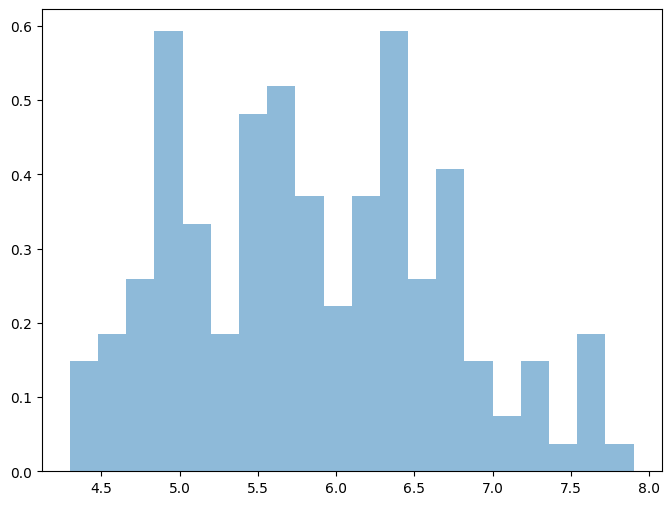

In [26]:
data = pd.read_csv("iris.csv")

print(data.head())

features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

for feature in features:
    print(f"Analizăm caracteristica: {feature}")

    values = data[feature].values

    with pm.Model() as model:
        weights = pm.Dirichlet("weights", a=np.ones(3))

        means = pm.Normal("means", mu=np.mean(values), sigma=5, shape=3)
        sds = pm.HalfNormal("sds", sigma=2, shape=3)

        components = pm.Normal.dist(mu=means, sigma=sds, shape=(3,))
        mixture = pm.Mixture("mixture", w=weights, comp_dists=components, observed=values)

        trace = pm.sample(1000, tune=500, return_inferencedata=True)

    print(pm.summary(trace, var_names=["weights", "means", "sds"]))

    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=20, density=True, alpha=0.5, label=f"Observații ({feature})")
    for i in range(3):
        plt.plot(
            np.linspace(values.min(), values.max(), 100),
            pm.Normal.dist(
                mu=trace.posterior["means"].mean(("chain", "draw")).values[i],
                sigma=trace.posterior["sds"].mean(("chain", "draw")).values[i]
            ).logp(np.linspace(values.min(), values.max(), 100)).eval(),
            label=f"Componenta {i+1}"
        )
    plt.title(f"Distribuția mixtă pentru {feature}")
    plt.legend()
    plt.show()

In [ ]:
# Caracteristica ce separă cel mai bine datele este determinată prin:
# - Mediile estimate ale componentelor: cele mai distincte indică o separare mai buna.
# - Deviatii standard mici: arata suprapuneri minime între grupele identificate.
# - Vizualizarea clustering-ului: grupe bine delimitate în grafice sugerează separare optimă.
# - Scorul Silhouette: un scor mai mare indică separare optimă între grupe.

# În setul de date Iris, de obicei, petal_length și petal_width separă cel mai bine speciile.